## 任务2
在VOC数据集上训练并测试目标检测模型Faster R-CNN和YOLO V3



### 实验配置

#### 环境搭建
我们将使用`mmdetection`来完成这个任务。

首先需要安装`pytorch`，由于`mmdetection`的兼容性，需要安装`cuda 11.7`版本对应的`torch 2.0.1`：

```bash
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
```
> FYI，在Windows上可以同时安装多个版本的cuda，只要指定环境变量`CUDA_PATH`即可修改默认的cuda。


然后我们安装`openmim`，用它来安装`mmdetection`：
```bash
pip3 install -U openmim
mim install mmengine
mim install "mmcv==2.1.0"
mim install mmdet
```

#### 数据集
我们使用的是VOC2012数据集。
> VOC2012这个挑战的目标是从现实场景中的许多视觉对象类别中识别对象（即不是预先分割的对象）。它基本上是一个监督学习问题，因为它提供了一组标记图像的训练集。已选择的 20 个对象类别是： 人：人 动物：鸟、猫、牛、狗、马、羊 交通工具：飞机、自行车、船、公共汽车、汽车、摩托车、火车 室内：瓶子、椅子、餐桌、盆栽、沙发、电视/显示器 将有两个主要比赛和两个较小规模的“品尝者”比赛。内容：提供的训练数据由一组图像组成；每个图像都有一个注释文件，为图像中存在的 20 个类别之一中的每个对象提供一个边界框和对象类别标签。请注意，来自多个类的多个对象可能出现在同一图像中。

##### 下载
```bash
python tools/misc/download_dataset.py --dataset-name voc2012
```

##### 组织
数据下载完之后，解压到data文件夹得到如下的结构：
```
data
└─coco
    └─VOCtrainval_11-May-2012
        └─VOCdevkit
            └─VOC2012
                ├─Annotations
                ├─ImageSets
                │  ├─Action
                │  ├─Layout
                │  ├─Main
                │  └─Segmentation
                ├─JPEGImages
                ├─SegmentationClass
                └─SegmentationObject
```
该数据集共计17125个图像。
##### 划分
我们使用数据集自带的划分：
```
data/coco/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Main/train.txt
```
（共计5717个图像）作为训练集。

使用数据集自带的划分：
```
data/coco/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Main/val.txt
```
（共计5717个图像）作为测试集。

In [1]:
# 虽然看起来很奇怪，我们的训练集和测试集都是5717个图像，你可能会怀疑这俩不会是完全一样的吧？
# 但是他们真的是完全独立的，不信你看：
val_path = r"data\coco\VOCtrainval_11-May-2012\VOCdevkit\VOC2012\ImageSets\Main\val.txt"
with open(val_path) as f:
    val = f.read().split()
train_path = r"data\coco\VOCtrainval_11-May-2012\VOCdevkit\VOC2012\ImageSets\Main\train.txt"
with open(train_path) as f:
    train = f.read().split()
all(i not in val for i in train)

True

#### 模型训练
使用mmdetection提供的脚本：
##### Faster R-CNN

正常训练：
```bash
python tools/train.py configs/faster_rcnn/faster-rcnn_r50_fpn_1x_voc.py
```

从断点继续训练：
```bash
python tools/train.py configs/faster_rcnn/faster-rcnn_r50_fpn_1x_voc.py --resume [checkpoint.pth]
```

##### YOLO V3
正常训练：
```bash
python tools/train.py configs/yolo/yolov3_d53_8xb8-ms-608-273e_voc_base.py
```

从断点继续训练：
```bash
python tools/train.py configs/yolo/yolov3_d53_8xb8-ms-608-273e_voc_base.py --resume [checkpoint.pth]
```

训练完的日志和权重保存在work_dirs文件夹。

#### 模型测试
使用mmdetection提供的脚本：
##### Faster R-CNN
```bash
python tools/test.py configs/faster_rcnn/faster-rcnn_r50_fpn_1x_voc.py work_dirs/faster-rcnn_r50_fpn_1x_voc/epoch_10.pth
```
##### YOLO V3
```bash
python tools/test.py configs/yolo/yolov3_d53_8xb8-ms-608-273e_voc_base.py work_dirs/yolov3_d53_8xb8-ms-608-273e_voc_base/epoch_100.pth
```

#### 模型推理

```bash
python inference.py
```
一例：

- 原图：
    - ![alt text](demo/in/2009_000759.jpg)
- 可视化bounding box：
    - ![alt text](outputs/in/vis/2009_000759.jpg)

### 模型细节
*（发现的太晚，由于yolo的训练太慢了。实在是没时间再重新跑实验了）*
> 所有实验设置的num_classes都错误地设置成了80。  
> 可以理解为，我们本来要分80类，但是训练数据只给了前20类。  
> 训练难度大增，但是模型还是给出了一些有意义的结果。  
>  

#### Faster R-CNN

- 网络结构：
    - back_bone: resnet50
    - neck: FPN
    - roi_head: StandardRoIHead
    - rpn_head: AnchorGenerator+DeltaXYWHBBoxCoder
- batch size
    - train batch size: 4
    - val or test batch size: 3
- learning rate
    - LinearLR
- 优化器
    - SGD
    - momentum=0.9
    - lr=0.02
    - weight_decay=0.0001
- epoch: 10
- loss function
    - loss_bbox: L1Loss
    - loss_cls: CrossEntropyLoss
- 评价指标
    - mAP(eval_mode is area)

#### YOLO v3
- 网络结构：
    - back_bone: darknet53
    - bbox_head: YOLOV3Head
    - neck: YOLOV3Neck
- batch size
    - train batch size: 4
    - val or test batch size: 3
- learning rate
    - LinearLR
- 优化器
    - SGD
    - momentum=0.9
    - lr=0.001
    - weight_decay=0.0005
- epoch: 150
- loss function
    - loss_conf: CrossEntropyLoss
    - loss_cls: CrossEntropyLoss
    - loss_wh: MSELoss
    - loss_xy: CrossEntropyLoss
- 评价指标
    - mAP(eval_mode is area)

### 实验结果

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd

#### test结果（使用text_xxx.sh脚本）

##### Faster R-CNN

```
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| aeroplane   | 433  | 749  | 0.801  | 0.765 |
| bicycle     | 358  | 696  | 0.791  | 0.736 |
| bird        | 559  | 902  | 0.712  | 0.648 |
| boat        | 424  | 716  | 0.481  | 0.387 |
| bottle      | 630  | 579  | 0.406  | 0.353 |
| bus         | 301  | 496  | 0.807  | 0.777 |
| car         | 1004 | 1327 | 0.644  | 0.612 |
| cat         | 612  | 1174 | 0.907  | 0.854 |
| chair       | 1176 | 2592 | 0.577  | 0.447 |
| cow         | 298  | 789  | 0.742  | 0.573 |
| diningtable | 305  | 988  | 0.692  | 0.536 |
| dog         | 759  | 1604 | 0.884  | 0.811 |
| horse       | 360  | 922  | 0.828  | 0.731 |
| motorbike   | 356  | 747  | 0.829  | 0.773 |
| person      | 4372 | 5798 | 0.773  | 0.731 |
| pottedplant | 489  | 776  | 0.521  | 0.379 |
| sheep       | 413  | 609  | 0.692  | 0.635 |
| sofa        | 285  | 1132 | 0.835  | 0.588 |
| train       | 315  | 731  | 0.803  | 0.750 |
| tvmonitor   | 392  | 597  | 0.702  | 0.647 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.637 |
+-------------+------+------+--------+-------+
```

In [3]:
!cat work_dirs/faster-rcnn_r50_fpn_1x_voc/20240529_190915/20240529_190915.json

{"pascal_voc/mAP": 0.6365931630134583, "pascal_voc/AP50": 0.637, "data_time": 0.007022803496724855, "time": 0.1656946580720771}


##### YOLO V3
效果很差，大概是因为numclass设置成了80

```
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 433  | 0     | 0.000  | 0.000 |
| bicycle     | 358  | 0     | 0.000  | 0.000 |
| bird        | 559  | 0     | 0.000  | 0.000 |
| boat        | 424  | 0     | 0.000  | 0.000 |
| bottle      | 630  | 0     | 0.000  | 0.000 |
| bus         | 301  | 0     | 0.000  | 0.000 |
| car         | 1004 | 0     | 0.000  | 0.000 |
| cat         | 612  | 50946 | 0.152  | 0.000 |
| chair       | 1176 | 0     | 0.000  | 0.000 |
| cow         | 298  | 0     | 0.000  | 0.000 |
| diningtable | 305  | 15504 | 0.023  | 0.000 |
| dog         | 759  | 0     | 0.000  | 0.000 |
| horse       | 360  | 0     | 0.000  | 0.000 |
| motorbike   | 356  | 0     | 0.000  | 0.000 |
| person      | 4372 | 0     | 0.000  | 0.000 |
| pottedplant | 489  | 0     | 0.000  | 0.000 |
| sheep       | 413  | 0     | 0.000  | 0.000 |
| sofa        | 285  | 0     | 0.000  | 0.000 |
| train       | 315  | 0     | 0.000  | 0.000 |
| tvmonitor   | 392  | 0     | 0.000  | 0.000 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.000 |
+-------------+------+-------+--------+-------+
```

In [4]:
!cat work_dirs/yolov3_d53_8xb8-ms-608-273e_voc_base/20240531_205942/20240531_205942.json

{"pascal_voc/mAP": 2.2725438611814752e-05, "pascal_voc/AP50": 0.0, "data_time": 0.007086128503130245, "time": 0.12972370034207517}


#### loss曲线（读取mmdetection的训练日志）

##### Faster R-CNN

In [5]:
scalars = []
with open('./work_dirs/faster-rcnn_r50_fpn_1x_voc/20240529_125217/vis_data/scalars.json') as f:
    while True:
        line = f.readline()
        if line:
            scalars.append(json.loads(line))
        else:
            break

In [6]:
df = pd.DataFrame(scalars)
df.head(2)

,lr,data_time,loss,loss_rpn_cls,loss_rpn_bbox,loss_cls,acc,loss_bbox,time,epoch,iter,memory,step,pascal_voc/mAP,pascal_voc/AP50
0,0.001982,0.288859,1.326997,0.355577,0.020233,0.897574,95.898438,0.053614,0.803704,1.0,50.0,4252.0,50,NaN,NaN
1,0.003984,0.001500,0.523136,0.058601,0.018267,0.288531,95.361328,0.157737,0.486069,1.0,100.0,4252.0,100,NaN,NaN


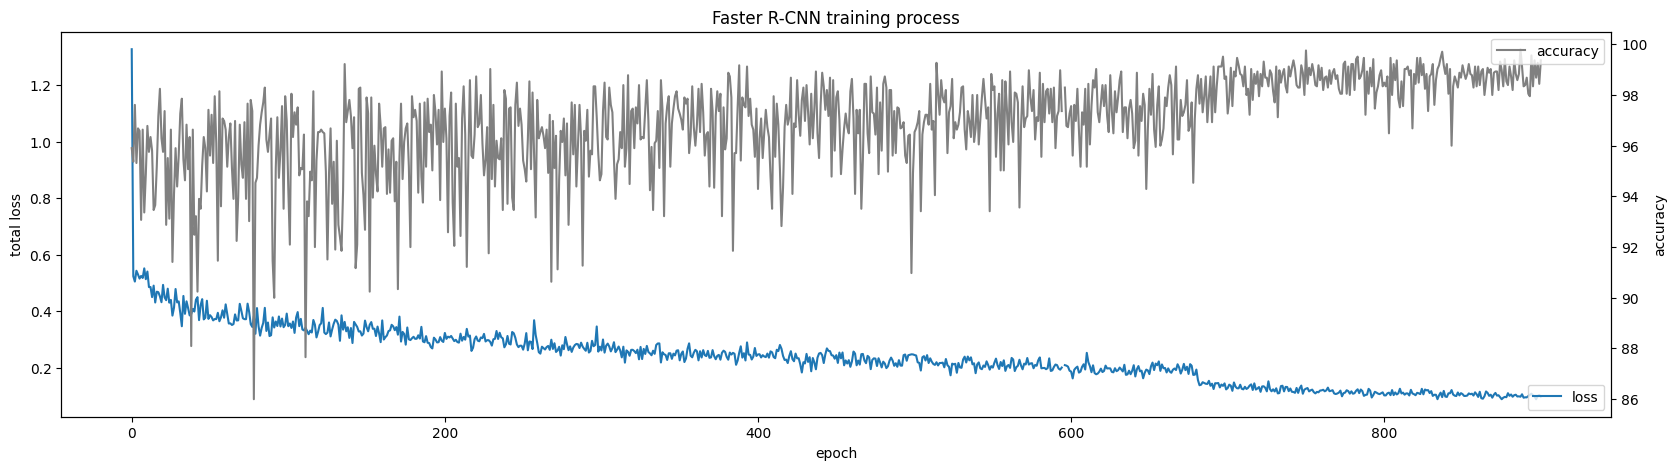

In [7]:
fig, ax = plt.subplots(figsize=(20,5))
ax_t = ax.twinx()
ax.plot(df.loss, label='loss')
ax.set_title('Faster R-CNN training process')
ax.set_ylabel('total loss')
ax.set_xlabel('epoch')
ax_t.set_ylabel('accuracy')
ax_t.plot(df.acc, label='accuracy', color='gray')
ax.legend(loc='lower right')
ax_t.legend(loc='upper right')
plt.show()

##### YOLO V3

In [8]:
scalars = []
with open('./work_dirs/yolov3_d53_8xb8-ms-608-273e_voc_base/20240530_195334/vis_data/scalars.json') as f:
    while True:
        line = f.readline()
        if line:
            scalars.append(json.loads(line))
        else:
            break

In [9]:
df = pd.DataFrame(scalars)
df.head(2)

,lr,data_time,grad_norm,loss,loss_cls,loss_conf,loss_xy,loss_wh,time,epoch,iter,memory,step,pascal_voc/mAP,pascal_voc/AP50
0,0.001,0.258226,125.779447,116.694597,27.225264,62.711690,21.918385,4.839258,0.723536,57.0,240178.0,6053.0,240178,NaN,NaN
1,0.001,0.002813,144.374130,131.035503,30.971921,69.433299,24.852471,5.777812,0.430632,57.0,240228.0,6048.0,240228,NaN,NaN


<Axes: >

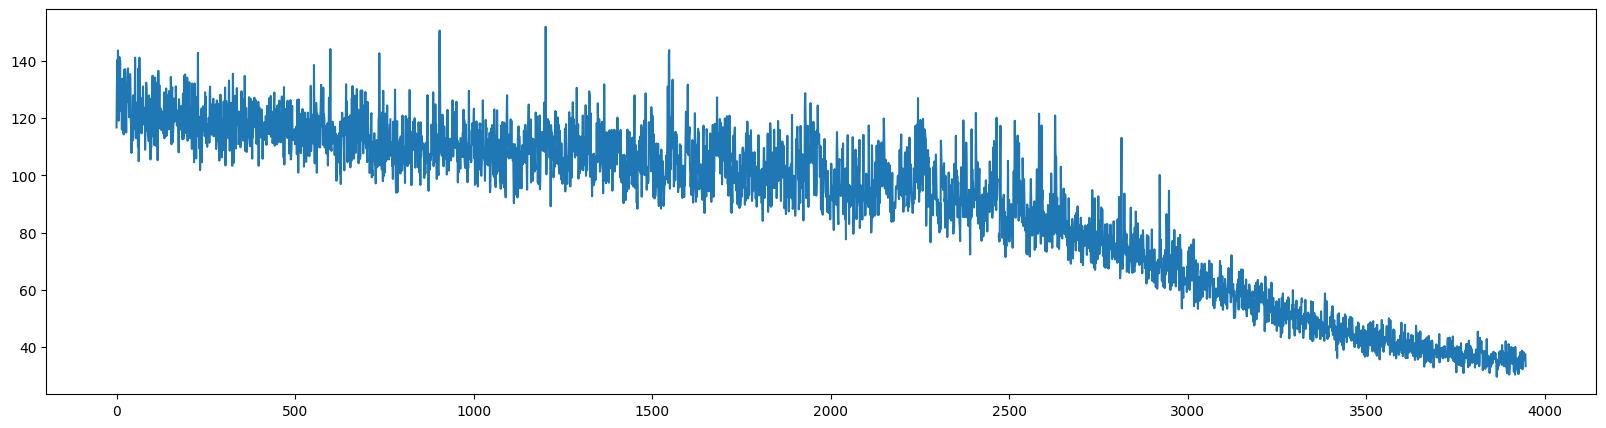

In [10]:
df.loss.plot(figsize=(20,5))

#### Faster R-CNN两阶段可视化


In [11]:
import mmcv
import torch
from mmdet.apis import init_detector

# 配置文件路径
config_file = r"work_dirs\faster-rcnn_r50_fpn_1x_voc\faster-rcnn_r50_fpn_1x_voc.py"
# 预训练模型路径
checkpoint_file = r"work_dirs\faster-rcnn_r50_fpn_1x_voc\epoch_10.pth"
# 输入图像路径
img_path = r"demo\in\2007_000822.jpg"

# 加载模型
model = init_detector(config_file, checkpoint_file, device="cuda:0")

# 输入
img = mmcv.imread(img_path)
img = torch.from_numpy(img)
img = img.unsqueeze(0).permute((0, 3, 1, 2)).cuda().float()

# 获取 RPN 结果
with torch.no_grad():
    features = model.extract_feat(img)
    rpn_outs = model.rpn_head(features)


Loads checkpoint by local backend from path: work_dirs\faster-rcnn_r50_fpn_1x_voc\epoch_10.pth


In [15]:
type(rpn_outs), type(rpn_outs[0]), type(rpn_outs[0][0]), rpn_outs[0][0].shape

(tuple, list, torch.Tensor, torch.Size([1, 3, 94, 125]))

根据我看源代码的结果，这里应该是需要使用`model.roi_head.predict_bbox`来计算一个bbox出来
```python
def predict_bbox(self,
                    x: Tuple[Tensor],
                    batch_img_metas: List[dict],
                    rpn_results_list: InstanceList,
                    rcnn_test_cfg: ConfigType,
                    rescale: bool = False) -> InstanceList:
    """Perform forward propagation of the bbox head and predict detection
    results on the features of the upstream network.

    Args:
        x(tuple[Tensor]): Feature maps of all scale level.
        batch_img_metas (list[dict]): List of image information.
        rpn_results_list (list[:obj:`InstanceData`]): List of region
            proposals.
        rcnn_test_cfg (obj:`ConfigDict`): `test_cfg` of R-CNN.
        rescale (bool): If True, return boxes in original image space.
            Defaults to False.

    Returns:
        list[:obj:`InstanceData`]: Detection results of each image
        after the post process.
        Each item usually contains following keys.

        - scores (Tensor): Classification scores, has a shape
            (num_instance, )
        - labels (Tensor): Labels of bboxes, has a shape
            (num_instances, ).
        - bboxes (Tensor): Has a shape (num_instances, 4),
            the last dimension 4 arrange as (x1, y1, x2, y2).
    """
```

但是有bug我解决不了，只能止步于此了

In [ ]:
img_metas = [{"filename": img_path, "ori_shape": (img.shape[2], img.shape[3], 3)}]
proposal_list = model.roi_head.predict_bbox(features,img_metas, *rpn_outs, model.test_cfg)


# 保存 RPN 结果
for i, proposals in enumerate(proposal_list):
    img_meta = img_metas[i]
    img_name = os.path.basename(img_meta["filename"])
    proposals_np = proposals.cpu().numpy()
    np.savetxt(f"{img_name}_rpn_proposals.txt", proposals_np, fmt="%f")

#### yolov3 VS faster r-cnn可视化

In [30]:
from mmdet.apis import DetInferencer
import warnings
warnings.filterwarnings('ignore')

In [31]:
inferencer_frcnn = DetInferencer(
    weights='work_dirs/faster-rcnn_r50_fpn_1x_voc/epoch_10.pth',
    device='cuda:0'
)
res = inferencer_frcnn('demo/out', out_dir='outputs/out/rcnn', no_save_pred=False)

Loads checkpoint by local backend from path: work_dirs/faster-rcnn_r50_fpn_1x_voc/epoch_10.pth


Output()

In [32]:
inferencer_yolo = DetInferencer(
    weights='work_dirs/yolov3_d53_8xb8-ms-608-273e_voc_base/epoch_100.pth',
    device='cuda:0'
)
res = inferencer_yolo('demo/out', out_dir='outputs/out/yolo', no_save_pred=False)

Loads checkpoint by local backend from path: work_dirs/yolov3_d53_8xb8-ms-608-273e_voc_base/epoch_100.pth


Output()

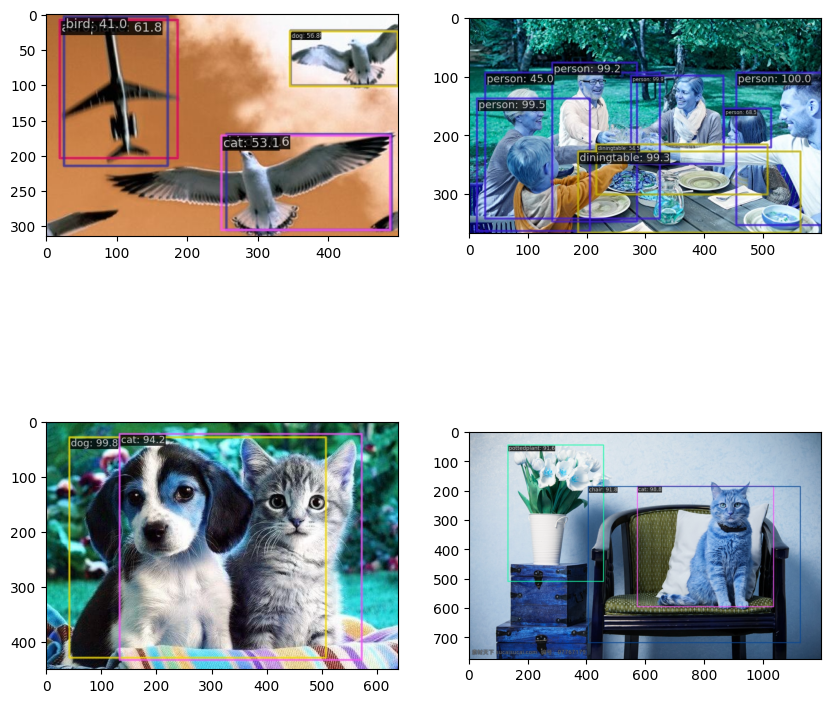

In [34]:
import mmcv
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0][0].imshow(mmcv.imread('./outputs/out/rcnn/vis/plane.jpg'))
axes[0][1].imshow(mmcv.imread('./outputs/out/rcnn/vis/eating_people.jpg'))
axes[1][0].imshow(mmcv.imread('./outputs/out/rcnn/vis/cat+dog.jpg'))
axes[1][1].imshow(mmcv.imread('./outputs/out/rcnn/vis/cat+chair.jpg'))

yolo 全部失败了

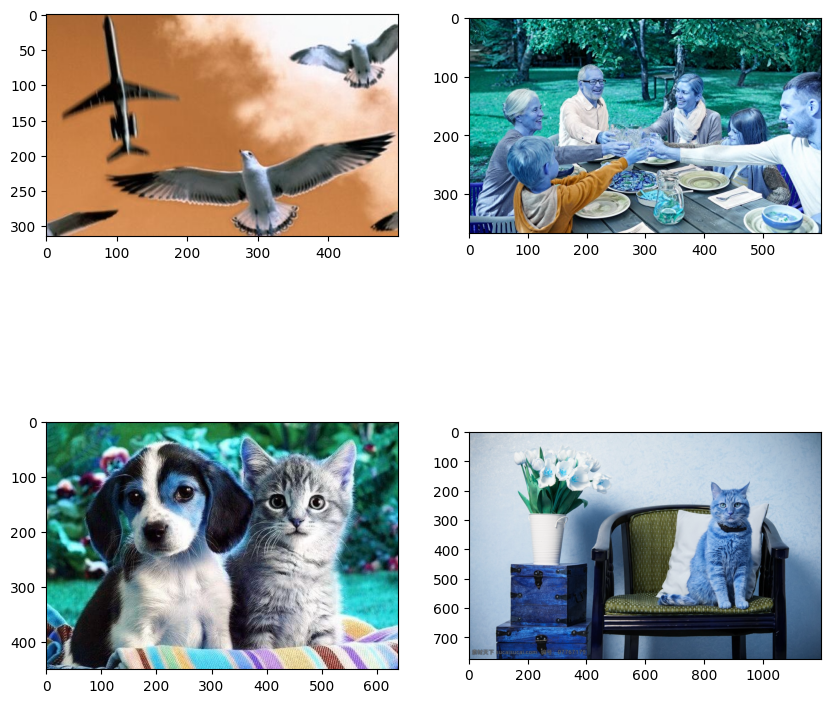

In [35]:
import mmcv
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0][0].imshow(mmcv.imread('./outputs/out/yolo/vis/plane.jpg'))
axes[0][1].imshow(mmcv.imread('./outputs/out/yolo/vis/eating_people.jpg'))
axes[1][0].imshow(mmcv.imread('./outputs/out/yolo/vis/cat+dog.jpg'))
axes[1][1].imshow(mmcv.imread('./outputs/out/yolo/vis/cat+chair.jpg'))